In [1]:
import random
import os
import matplotlib.pylab as plt
from glob import glob
import numpy as np
import webcolors
%matplotlib inline

In [2]:
PATH = os.path.abspath('data')

SOURCE_IMAGES = os.path.join(PATH, "images/resized/*")

images = glob(os.path.join(SOURCE_IMAGES, "*.jpg"))

SOURCE_LABELS = os.path.join(PATH, "labels/resized/*")

labels = glob(os.path.join(SOURCE_LABELS, "*.png"))

In [3]:
images.sort()
labels.sort()
print(np.size(images))
print(np.size(labels))

143
143


In [12]:
x = [] # images
y = [] # labels

for img in images:
    full_size_image = plt.imread(img)
    x.append(full_size_image)

for lbl in labels:
    full_size_label = plt.imread(lbl,0)
    y.append(full_size_label)
    
x = np.asarray(x)
y = np.asarray(y)

cs = ['background','asphalt', 'building', 'forest', 'grass', 'ground', 'roadAsphalt', 'roadGround', 'water']

print(y.min())
print(y.max())
print(x.shape)
print(y.shape)

0
8
(143, 512, 640, 3)
(143, 512, 640)


In [8]:
hex_colors = ['#000000','#4A4A4A','#FF0000', '#407700', '#00FF37', '#8B572A', '#0000FF', '#FF7600', '#50E3C2']

rgb_colors = []

for hex_color in hex_colors:
    rgb_colors.append(webcolors.hex_to_rgb(hex_color))
    
def colorize(mask, colors):
    colorMask = np.zeros([mask.shape[0], mask.shape[1], 3],dtype=np.uint8)
    for r in range(mask.shape[0]):
        for c in range(mask.shape[1]):
            colorMask[r,c,] = colors[mask[r,c]]

    return colorMask

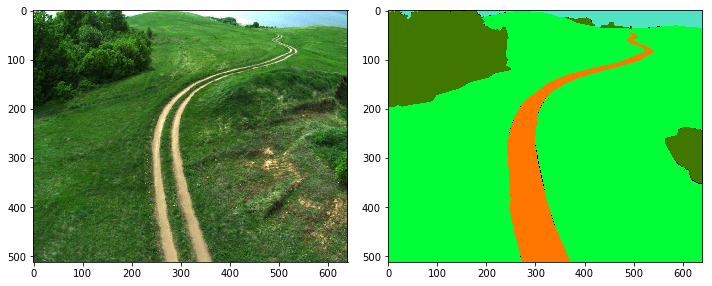

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10,5)
axes[0].imshow(x[0])
axes[1].imshow(colorize(y[0], colors = np.array(rgb_colors)))
fig.tight_layout()

In [10]:
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

In [11]:
def elastic_transform_together(image, mask, n_classes, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of RGB images and their grayscale masks for multiclass semantic segmentation
        Shape of image is h,w,3
        Shape of mask is h,w
        n_classes is a number of classes for segmentation
     Based on https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation which is based
     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    
    # IMAGE
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dx, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    
    img_et = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape) 

    # MASK
    shape = mask.shape
        
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dx, (-1, 1)), np.reshape(x+dx, (-1, 1))
    
    msk_all = np.zeros(np.append(shape, n_classes))
    
    for i in range(n_classes):
        msk = cv2.warpAffine(np.uint8(mask == i), M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
        msk_all[:,:,i] = map_coordinates(msk, indices, order=1, mode='reflect').reshape(shape)
        
    msk_et = np.argmax(msk_all,axis=-1)

    return img_et, msk_et

In [25]:
img = x[0].copy()
msk = y[0].copy()

n_classes = len(cs)

alpha = img.shape[1] * 0.5
sigma = img.shape[1] * 0.15
alpha_affine = img.shape[1] * 0.1

img_et, msk_et = elastic_transform_together(img, msk, 9, alpha, sigma, alpha_affine)

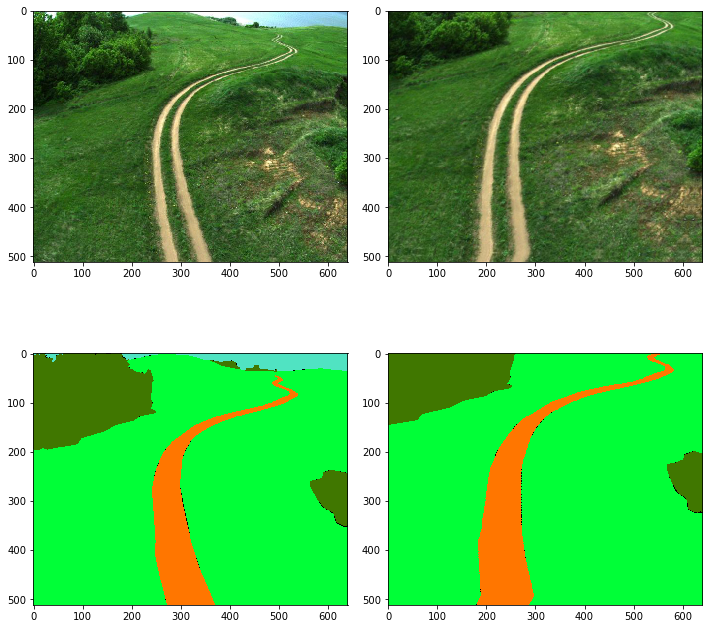

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10,10)
axes[0,0].imshow(img)
axes[0,1].imshow(img_et)
axes[1,0].imshow(colorize(msk, colors = np.array(rgb_colors)))
axes[1,1].imshow(colorize(msk_et, colors = np.array(rgb_colors)))
fig.tight_layout()

In [28]:
print(np.unique(msk))
print(np.unique(msk_et))

[0 3 4 7 8]
[0 3 4 7]
